In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import albumentations as A
from ultralytics import YOLO
import os
import cv2
import albumentations as A
import numpy as np
from tqdm import tqdm
import torch

In [ ]:
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.4),
    A.GaussianBlur(p=0.2),
    A.GaussNoise(p=0.3),
    A.Rotate(limit=5, p=0.3),
    A.PadIfNeeded(min_height=640, min_width=640, border_mode=0, value=0),
    A.Resize(640, 640),
    A.MotionBlur(p=0.1),
    A.ImageCompression(quality_lower=50, quality_upper=100, p=0.3),
    A.CLAHE(p=0.2),

], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

/tmp/ipython-input-3-2158888759.py:7: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=640, min_width=640, border_mode=0, value=0),
/tmp/ipython-input-3-2158888759.py:10: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=50, quality_upper=100, p=0.3),


In [ ]:
input_images_dir = '/content/drive/MyDrive/FinGPT-M_YOLO/train/images'
input_labels_dir = '/content/drive/MyDrive/FinGPT-M_YOLO/train/labels'
output_images_dir = '/content/drive/MyDrive/FinGPT-M_YOLO/augmented/images'
output_labels_dir = '/content/drive/MyDrive/FinGPT-M_YOLO/augmented/labels'

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

image_filenames = [f for f in os.listdir(input_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [ ]:
for image_file in tqdm(image_filenames, desc="Augmenting images"):
    image_path = os.path.join(input_images_dir, image_file)
    label_path = os.path.join(input_labels_dir, os.path.splitext(image_file)[0] + '.txt')

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    bboxes = []
    class_labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x, y, w, h = map(float, parts)
                bboxes.append([x, y, w, h])
                class_labels.append(int(cls))

    for i in range(3):
        try:
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_labels = augmented['class_labels']

            aug_filename = f"{os.path.splitext(image_file)[0]}_aug{i}.jpg"
            aug_image_path = os.path.join(output_images_dir, aug_filename)
            cv2.imwrite(aug_image_path, aug_img)

            aug_label_path = os.path.join(output_labels_dir, f"{os.path.splitext(image_file)[0]}_aug{i}.txt")
            with open(aug_label_path, 'w') as f:
                for label, bbox in zip(aug_labels, aug_bboxes):
                    f.write(f"{label} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

        except Exception as e:
            print(f"Failed to augment {image_file} (attempt {i}): {e}")

Augmenting images: 100%|██████████| 105/105 [01:10<00:00,  1.49it/s]


In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!git clone https://github.com/ultralytics/ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 62161, done.
remote: Counting objects: 100% (531/531), done.
remote: Compressing objects: 100% (355/355), done.
remote: Total 62161 (delta 419), reused 182 (delta 176), pack-reused 61630 (from 5)
Receiving objects: 100% (62161/62161), 33.94 MiB | 24.12 MiB/s, done.
Resolving deltas: 100% (46204/46204), done.


In [ ]:
model = YOLO('yolo11s.pt')

results = model.train(
    data="/content/drive/MyDrive/FinGPT-M_YOLO/data.yaml",
    imgsz=640,
    epochs=150,
    batch=16,
    hsv_h=0.015,      # Slight hue jitter; higher values can alter typical chart colors
    hsv_s=0.6,        # Stronger saturation jitter for style generalization
    hsv_v=0.4,        # Moderate brightness variability
    degrees=5.0,      # Mild rotation; higher can distort axes/legends
    translate=0.05,   # Small translations to simulate minor cropping/shifting
    scale=0.2,        # Slight zoom in/out
    shear=0.03,       # Low shear to avoid distorting chart patterns
    perspective=0.0,  # Disable perspective warp for precise trend lines
    fliplr=0.25,      # Occasional horizontal flip (ok for symmetrical patterns)
    flipud=0.0,       # Disable vertical flip (not meaningful for most charts)
    mosaic=1.0,       # Enable mosaic (YOLO default), increases context diversity
    mixup=0.1,        # Low mixup; helps regularize, but don't overuse for fine features
    # Additional settings
    lr0=0.01,
    patience=30,
    save=True,
    save_period=10,
    cos_lr=True,
    name='YOLOv_Augmented_Training',
    device=0,
    amp=False,
)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.7.1+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/FinGPT-M_YOLO/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.25, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOv_Augmented_Training2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30, perspective=0.

train: Scanning /content/drive/MyDrive/FinGPT-M_YOLO/train/labels... 600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 600/600 [04:52<00:00,  2.05it/s]

train: New cache created: /content/drive/MyDrive/FinGPT-M_YOLO/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.1±0.0 MB/s, size: 45.3 KB)


val: Scanning /content/drive/MyDrive/FinGPT-M_YOLO/val/labels... 200 images, 1 backgrounds, 0 corrupt: 100%|██████████| 200/200 [01:38<00:00,  2.04it/s]

val: New cache created: /content/drive/MyDrive/FinGPT-M_YOLO/val/labels.cache


Plotting labels to runs/detect/YOLOv_Augmented_Training2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/YOLOv_Augmented_Training2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      7.49G      2.033      5.338      2.013         22        640: 100%|██████████| 38/38 [00:23<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        200        331      0.327      0.203     0.0335     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      7.73G      1.589      3.635       1.67         34        640: 100%|██████████| 38/38 [00:21<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200        331      0.167      0.338     0.0621     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      7.64G       1.55      3.256      1.663         26        640: 100%|██████████| 38/38 [00:21<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


                   all        200        331      0.386      0.104     0.0896     0.0451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      7.64G      1.565      3.126      1.673         24        640: 100%|██████████| 38/38 [00:21<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200        331     0.0872      0.241     0.0999     0.0516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      7.65G      1.538      2.978      1.693         16        640: 100%|██████████| 38/38 [00:22<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200        331      0.359      0.122     0.0766      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      7.63G      1.484      2.898       1.63         30        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200        331     0.0934      0.301      0.151     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      7.61G      1.473       2.87      1.614         28        640: 100%|██████████| 38/38 [00:22<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        200        331      0.299      0.213      0.197       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      7.64G      1.486      2.787      1.637         25        640: 100%|██████████| 38/38 [00:22<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


                   all        200        331      0.366       0.19      0.162     0.0919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      7.64G      1.414      2.738      1.565         28        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200        331      0.282      0.335      0.205      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      7.64G      1.395      2.689      1.567         22        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200        331      0.311      0.303      0.194      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      7.63G      1.393      2.626      1.566         27        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        200        331      0.311      0.273       0.24      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      7.63G      1.351      2.527      1.538         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all        200        331      0.353      0.315      0.255      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      7.63G      1.302      2.535      1.496         25        640: 100%|██████████| 38/38 [00:22<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200        331      0.388      0.279      0.253      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      7.64G      1.295      2.468      1.522         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200        331      0.259      0.345      0.237      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      7.63G       1.29      2.408      1.494         21        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200        331      0.227       0.34       0.26      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      7.65G      1.282      2.377      1.511         27        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

                   all        200        331       0.27      0.336       0.29      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      7.63G      1.237      2.341       1.49         25        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        200        331      0.295      0.373      0.288      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      7.64G      1.237      2.293      1.469         27        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200        331      0.233      0.377      0.277      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      7.63G      1.233      2.291      1.471         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200        331      0.276       0.39      0.299      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      7.63G      1.189      2.202      1.454         28        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200        331      0.328      0.314      0.292      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      7.61G      1.203      2.217       1.46         24        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        200        331      0.258      0.445      0.305      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      7.63G      1.168      2.204       1.44         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        200        331      0.373      0.443      0.377      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      7.63G      1.172      2.121      1.433         33        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200        331      0.435      0.435      0.385      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      7.63G      1.146       2.14      1.408         27        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200        331      0.448      0.399      0.319      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      7.63G       1.16      2.101      1.416         21        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        200        331      0.379      0.441      0.377      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      7.63G      1.114       2.03      1.383         23        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        200        331      0.412      0.356      0.363      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      7.62G      1.132      2.026      1.397         29        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200        331      0.473      0.431      0.387      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      7.63G      1.084      1.961      1.357         22        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200        331      0.346      0.442      0.358      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      7.65G      1.099      2.027      1.395         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200        331      0.351      0.462      0.356       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      7.63G      1.068      1.947      1.347         34        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

                   all        200        331      0.392      0.516      0.396      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      7.63G      1.078      1.879      1.376         23        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        200        331      0.378      0.492      0.376      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      7.63G       1.07      1.899      1.362         22        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200        331      0.457      0.425      0.365      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      7.63G      1.051      1.841      1.343         23        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200        331      0.389      0.439      0.385      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      7.63G      1.021      1.842       1.34         32        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200        331      0.356      0.502      0.391      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      7.63G       1.01      1.803      1.321         18        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

                   all        200        331      0.478      0.431      0.432      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      7.65G      1.032      1.838      1.344         25        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        200        331      0.383      0.483      0.399      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      7.63G      1.039      1.795       1.36         29        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200        331      0.439      0.422      0.386      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      7.63G      1.009      1.768      1.321         27        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200        331      0.441      0.387      0.365      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      7.63G     0.9677      1.716      1.294         27        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200        331      0.487      0.401      0.415      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      7.64G     0.9779      1.671      1.292         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        200        331      0.412      0.544      0.405      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      7.64G     0.9422      1.719      1.283         33        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        200        331      0.368      0.431       0.35      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      7.64G      0.978      1.668      1.322         27        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        200        331      0.412      0.487      0.401      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      7.63G     0.9548      1.669      1.286         20        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200        331      0.398      0.486       0.39      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      7.64G     0.9521      1.697      1.277         24        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200        331      0.421      0.469      0.414       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      7.64G      0.942      1.611      1.285         33        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200        331      0.448      0.434      0.414      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      7.63G     0.9222      1.615      1.261         21        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200        331      0.419      0.456      0.419      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      7.63G     0.9068      1.555       1.26         32        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        200        331      0.391      0.486      0.415      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      7.63G     0.9442        1.6      1.277         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        200        331      0.596      0.395      0.434       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      7.63G     0.9137      1.545      1.263         35        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200        331      0.471      0.465      0.421      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      7.63G     0.8791      1.497      1.238         25        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200        331      0.432      0.485      0.421        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      7.64G     0.8901      1.517      1.245         24        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200        331      0.503      0.402      0.421      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      7.66G     0.8806      1.505      1.238         23        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]

                   all        200        331      0.441      0.471      0.419      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      7.63G      0.875       1.49      1.233         32        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


                   all        200        331      0.474       0.44      0.415      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      7.63G     0.8552      1.433      1.223         21        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        200        331      0.438      0.502      0.418      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      7.63G     0.8134      1.394      1.192         23        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200        331      0.441      0.519      0.437      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      7.63G     0.8528      1.444       1.21         21        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200        331      0.491      0.458       0.44       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      7.63G     0.8307      1.395      1.211         28        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200        331      0.407      0.504      0.439      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      7.64G     0.8054      1.381      1.189         20        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        200        331       0.45      0.411      0.417      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      7.63G     0.8329       1.42      1.203         27        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

                   all        200        331      0.499      0.436      0.426      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      7.63G      0.807      1.388      1.191         23        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200        331      0.431      0.472      0.435      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      7.64G     0.8188      1.368      1.199         24        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200        331      0.432      0.399      0.407      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      7.65G     0.8032      1.339      1.182         25        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200        331      0.496      0.492      0.454      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      7.63G     0.7888        1.3      1.172         25        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        200        331      0.502      0.429      0.422       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      7.63G     0.8106      1.386      1.193         20        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

                   all        200        331      0.393      0.358      0.321      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      7.63G     0.7722      1.313       1.17         33        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200        331      0.515      0.467       0.46      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      7.64G     0.7845      1.292      1.184         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200        331      0.479      0.465      0.433      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      7.66G     0.7761      1.286      1.166         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200        331      0.437      0.481      0.431      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      7.63G     0.7682       1.32      1.153         24        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        200        331      0.491       0.39      0.428      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      7.63G     0.7473      1.267      1.151         24        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

                   all        200        331      0.536      0.401      0.431       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      7.63G      0.743      1.244      1.153         35        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        200        331      0.485      0.489      0.444      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      7.63G     0.7277      1.225      1.143         30        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200        331      0.468       0.44      0.409      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      7.66G     0.7318      1.213      1.142         31        640: 100%|██████████| 38/38 [00:22<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200        331      0.445      0.483      0.421      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      7.63G     0.7573      1.267      1.165         24        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200        331      0.448      0.433      0.395      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      7.63G     0.7071        1.2      1.121         25        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all        200        331      0.535      0.397      0.422      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      7.63G     0.7159      1.217      1.131         24        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


                   all        200        331      0.468      0.462      0.423      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      7.63G     0.7156      1.181      1.138         30        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        200        331      0.468      0.469      0.431      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      7.65G     0.6974      1.132      1.124         33        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200        331      0.509      0.461      0.447      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      7.59G     0.7043      1.152      1.121         32        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200        331       0.46      0.449      0.434      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      7.63G      0.678      1.129      1.102         23        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        200        331      0.465      0.472      0.446      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      7.64G     0.6885      1.143      1.115         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        200        331      0.381      0.422      0.399      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      7.64G     0.7083      1.167      1.135         33        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200        331      0.435      0.446      0.418      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      7.59G     0.6795      1.113      1.105         32        640: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        200        331      0.513      0.482      0.443      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      7.64G     0.6641      1.061      1.097         30        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200        331      0.457       0.54      0.444      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      7.64G     0.6723      1.095      1.098         22        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        200        331      0.472      0.483      0.436      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      7.65G     0.6409      1.074      1.085         28        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        200        331      0.517      0.388      0.425      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      7.63G     0.7127      1.156      1.134         24        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200        331      0.436      0.437      0.403      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      7.63G     0.6794      1.103      1.118         37        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200        331      0.467      0.456      0.423      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      7.64G     0.6483      1.087      1.097         23        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200        331      0.424      0.455      0.415      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      7.65G     0.6491      1.083        1.1         27        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        200        331      0.402      0.432        0.4      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      7.63G      0.663      1.071        1.1         25        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


                   all        200        331       0.47      0.444       0.42      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      7.66G     0.6443      1.071      1.094         30        640: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


                   all        200        331      0.456      0.477      0.425      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      7.63G     0.6372      1.021      1.082         26        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200        331      0.425      0.494      0.417      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      7.63G     0.6477      1.061      1.095         24        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200        331      0.474      0.443      0.413      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      7.62G     0.6102      1.014      1.079         18        640: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200        331      0.484      0.439      0.415      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      7.64G     0.6241      1.035      1.079         18        640: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        200        331      0.423      0.422      0.387        0.3
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 65, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



95 epochs completed in 0.687 hours.
Optimizer stripped from runs/detect/YOLOv_Augmented_Training2/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/YOLOv_Augmented_Training2/weights/best.pt, 19.2MB

Validating runs/detect/YOLOv_Augmented_Training2/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.7.1+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,416,670 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


                   all        200        331      0.515      0.467       0.46      0.348
bearish_engulfing_fall         48         55      0.514      0.509      0.422      0.319
bullish_engulfing_rise         34         39      0.482      0.718      0.601      0.403
     evening_star_fall         15         15      0.596      0.733       0.56      0.384
           hammer_rise         13         13       0.61      0.308      0.437      0.339
      hanging_man_fall         20         21      0.414      0.429      0.397       0.35
   inverse_hammer_rise         30         33      0.526      0.273      0.358      0.228
     morning_star_rise         20         20      0.505        0.5      0.502      0.441
    shooting_star_fall         25         28      0.447      0.429      0.422      0.328
three_black_crows_fall         65         70      0.648      0.614      0.604      0.459
three_white_soldiers_rise         37         37      0.408      0.162      0.293      0.229
Speed: 0.2ms prepr

In [ ]:
val_model = YOLO("/content/runs/detect/YOLOv_Augmented_Training4/weights/best.pt")

val_results = val_model.val(
    data="/content/drive/MyDrive/FinGPT_YOLO_Training/data.yaml",
    imgsz=640,
    batch=16,
    device=0
)

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.7.1+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 52.3±12.8 MB/s, size: 105.1 KB)


val: Scanning /content/drive/MyDrive/FinGPT_YOLO_Training/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


                   all         45        277       0.28      0.333      0.215     0.0818
             Downtrend         44        115      0.322      0.365      0.268      0.113
              Sideways         33         63      0.155      0.302      0.112     0.0249
               Uptrend         44         99      0.362      0.333      0.265      0.107
Speed: 5.7ms preprocess, 26.1ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs/detect/val


Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.7.1+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/30 /content/drive/MyDrive/FinGPT_YOLO_Training/test/images/AMD-2_png.rf.637d99a7c6ac28704e661f0292365471.jpg: 384x640 3 Downtrends, 3 Sidewayss, 5 Uptrends, 51.4ms
image 2/30 /content/drive/MyDrive/FinGPT_YOLO_Training/test/images/BA2_png.rf.f204f2731b24aaa0a86895bcf8be6656.jpg: 256x640 3 Downtrends, 7 Sidewayss, 2 Uptrends, 51.7ms
image 3/30 /content/drive/MyDrive/FinGPT_YOLO_Training/test/images/BABA-2_png.rf.094d52d6b8467ee17fa24aa23a42a0b5.jpg: 384x640 5 Downtrends, 4 Uptrends, 11.7ms
image 4/30 /content/drive/MyDrive/FinGPT_YOLO_Training/test/images/BA_png.rf.a99df319b47635502ad09dd793e200fe.jpg: 256x640 (no detections), 10.2ms
image 5/30 /content/drive/MyDrive/FinGPT_YOLO_Training/test/images/CB-2_png.rf.ab03b4f83a934bd923fe55a901d8b6f0.jpg: 384x640 6 Downtrends, 7 Uptrends, 11.7ms
image 6/30 /content/drive

IndexError: index 2 is out of bounds for axis 0 with size 2

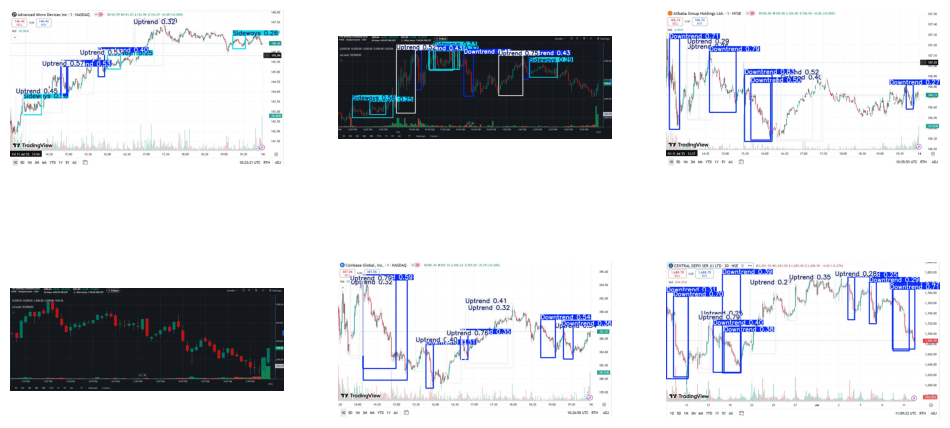

In [ ]:
!yolo predict model=/content/runs/detect/YOLOv_Augmented_Training4/weights/best.pt source='/content/drive/MyDrive/FinGPT_YOLO_Training/test/images' save=True

#plot
import os
import matplotlib.pyplot as plt

# Path to prediction folder
pred_path = 'runs/detect/predict'
pred_files = sorted(os.listdir(pred_path))

# Display a few predicted images
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for i in range(8):
    img = plt.imread(os.path.join(pred_path, pred_files[i]))
    row, col = i // 3, i % 3
    ax[row, col].imshow(img)
    ax[row, col].axis('off')
plt.tight_layout()
plt.show()